/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (17880, 18)
   job_id                                      title          location  \
0       1                           Marketing Intern  US, NY, New York   
1       2  Customer Service - Cloud Video Production    NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)     US, IA, Wever   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   

         

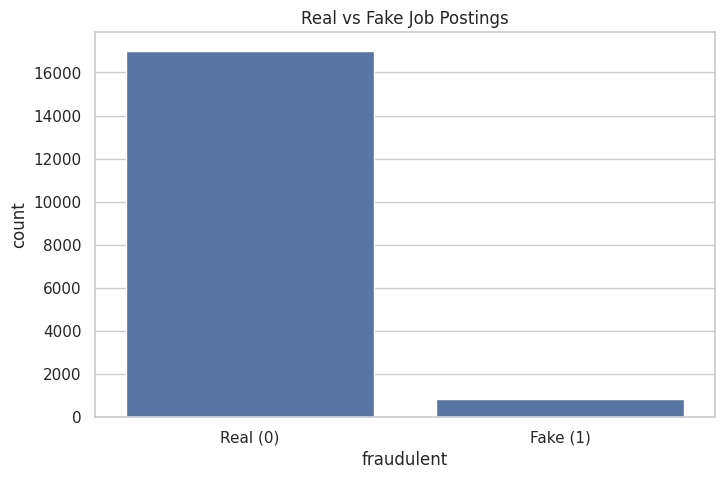


Sample clean text:
                                          clean_text  fraudulent
0  marketing intern us ny new york we re food52 a...           0
1  customer service cloud video production nz auc...           0
2  commissioning machinery assistant cma us ia we...           0

TF-IDF shape: (17880, 10000)

Confusion Matrix between True label and Cluster label:
[[  726 16288]
 [    0   866]]

Confusion Matrix after mapping cluster -> class:
[[16288   726]
 [  866     0]]

Classification Report (K-Means as unsupervised classifier):
              precision    recall  f1-score   support

           0     0.9495    0.9573    0.9534     17014
           1     0.0000    0.0000    0.0000       866

    accuracy                         0.9110     17880
   macro avg     0.4748    0.4787    0.4767     17880
weighted avg     0.9035    0.9110    0.9072     17880



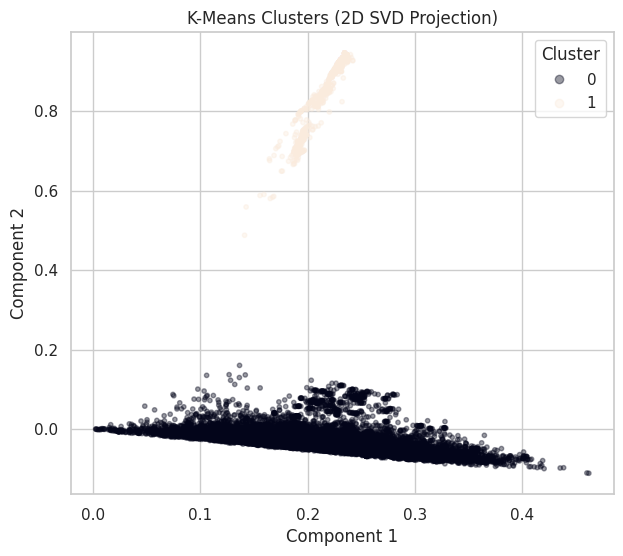


================= APRIORI RULE MINING ================
Number of fake job postings: 866

Top tokens among fake jobs:
['with', 'work', 'experience', 'skills', 'from', 'your', 'have', 'that', 'team', 'will', 'service', 'management', 'this', 'business', 'customer', 'time', 'company', 'ability', 'engineering', 'project', 'data', 'position', 'required', 'services', 'other', 'must', 'solutions', 'years', 'their', 'industry', 'support', 'products', 'looking', 'systems', 'development', 'knowledge', 'within', 'provide', 'information', 'people']

Transactions matrix:


In [12]:
# ============================================================
# Fake Job Posting Detection
# Using: TF-IDF + K-Means Clustering + Apriori Rule Mining
# ============================================================

# 0) Optional: Install extra library for Apriori
!pip install -q mlxtend

# 1) Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import TruncatedSVD

from mlxtend.frequent_patterns import apriori, association_rules

import re
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 2) Load dataset


from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/CSE-51/8Th/Data mining/lab/Fake job/fake_job_postings.csv')

print("Shape:", df.shape)
print(df.head(3))

print("\nColumns:", df.columns.tolist())

# 3) Basic info & class balance
# ------------------------------------------------------------
print("\nInfo:")
print(df.info())

print("\nFraudulent value counts:")
print(df['fraudulent'].value_counts())
print("\nFraudulent percentage:")
print(df['fraudulent'].value_counts(normalize=True) * 100)

sns.countplot(x='fraudulent', data=df)
plt.title("Real vs Fake Job Postings")
plt.xticks([0,1], ['Real (0)', 'Fake (1)'])
plt.show()

# 4) Text Preprocessing: combine useful text columns
# ------------------------------------------------------------
text_cols = ['title', 'location', 'company_profile', 'description', 'requirements']
for c in text_cols:
    df[c] = df[c].fillna('')

df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements']

def clean_text(s):
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['clean_text'] = df['text'].apply(clean_text)

print("\nSample clean text:")
print(df[['clean_text', 'fraudulent']].head(3))

# 5) TF-IDF Feature Extraction
# ------------------------------------------------------------
tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(df['clean_text'])
y = df['fraudulent'].values

print("\nTF-IDF shape:", X_tfidf.shape)

# 6) K-Means Clustering (unsupervised)
# ------------------------------------------------------------
k = 2
kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=10
)
kmeans.fit(X_tfidf)

cluster_labels = kmeans.labels_


cm = confusion_matrix(y, cluster_labels)
print("\nConfusion Matrix between True label and Cluster label:")
print(cm)

# If cluster 0 mostly real, map_0 -> 0 etc.
# We choose mapping that maximizes diagonal

if cm[0,0] + cm[1,1] >= cm[0,1] + cm[1,0]:
    # mapping: cluster 0 -> label 0, cluster 1 -> label 1
    y_pred = cluster_labels
else:
    # reverse mapping: cluster 0 -> 1, cluster 1 -> 0
    y_pred = 1 - cluster_labels

print("\nConfusion Matrix after mapping cluster -> class:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report (K-Means as unsupervised classifier):")
print(classification_report(y, y_pred, digits=4))

# 7) 2D Visualization using SVD (optional but good for PPT)
# ------------------------------------------------------------
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

plt.figure(figsize=(7,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_pred, alpha=0.4, s=10)
plt.title("K-Means Clusters (2D SVD Projection)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

# ============================================================
# PART B: APRIORI RULE MINING ON TEXT
# ============================================================
print("\n================= APRIORI RULE MINING ================")

# 8) Prepare transactions from fake job postings
# ------------------------------------------------------------
fake_df = df[df['fraudulent'] == 1].copy()
print("Number of fake job postings:", fake_df.shape[0])

def tokenize(s):
    tokens = s.split()
    tokens = [t for t in tokens if len(t) > 3]
    return tokens

fake_df['tokens'] = fake_df['clean_text'].apply(tokenize)

all_tokens = [t for tokens in fake_df['tokens'] for t in tokens]
freq = Counter(all_tokens)

# top 30-50 keyword
top_n = 40
top_tokens = [w for w, c in freq.most_common(top_n)]
print("\nTop tokens among fake jobs:")
print(top_tokens)

# 9) Build one-hot encoded DataFrame for Apriori
# ------------------------------------------------------------
def tokens_to_row(tokens, vocab):
    s = set(tokens)
    return [1 if v in s else 0 for v in vocab]

transactions_matrix = []
for tokens in fake_df['tokens']:
    row = tokens_to_row(tokens, top_tokens)
    transactions_matrix.append(row)

trans_df = pd.DataFrame(transactions_matrix, columns=top_tokens)
print("\nTransactions matrix:")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

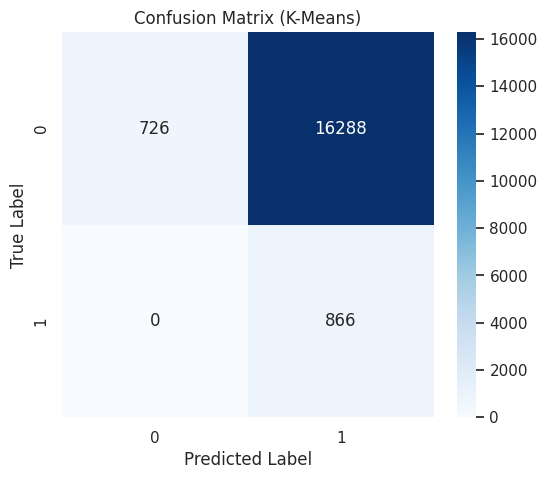

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [6]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (K-Means)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
print(trans_df.head())
print("Shape of transactions_matrix:", trans_df.shape)

   with  work  experience  skills  from  your  have  that  team  will  ...  \
0     1     1           1       1     1     1     1     0     1     0  ...   
1     1     0           0       1     1     0     0     0     0     1  ...   
2     1     1           1       1     1     1     1     1     0     0  ...   
3     0     0           0       0     0     0     0     0     0     0  ...   
4     1     1           1       1     1     1     1     0     1     0  ...   

   support  products  looking  systems  development  knowledge  within  \
0        1         0        0        1            0          1       1   
1        0         0        1        0            0          0       0   
2        1         0        0        1            0          1       1   
3        0         0        0        0            0          0       0   
4        1         0        0        1            0          1       1   

   provide  information  people  
0        1            0       0  
1        0        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag